# Et l’Homme… Réprima la Femme

## Importation des données de TMDb

In [1]:
# Traitement des données
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import ast

# Visualisation des données
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing avant le modèle
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Modèle de clustering
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from sklearn.cluster import KMeans

# Affichage des posters
from io import BytesIO
import urlopen
from PIL import Image
import requests

200


In [2]:
# Je récupère les couleurs du film Blade Runner pour créer une palette seaborn
from matplotlib.colors import ListedColormap, to_rgb, to_hex
Colors_Blade_Runner = [to_rgb('#021736'), to_rgb('#00466A'), to_rgb('#3992A4'), 
                       to_rgb('#38D3C5'), to_rgb('#B4E5C7'), to_rgb('#E4AFC3')]
Colors = sns.color_palette(Colors_Blade_Runner)
Colors

[(0.00784313725490196, 0.09019607843137255, 0.21176470588235294),
 (0.0, 0.27450980392156865, 0.41568627450980394),
 (0.2235294117647059, 0.5725490196078431, 0.6431372549019608),
 (0.2196078431372549, 0.8274509803921568, 0.7725490196078432),
 (0.7058823529411765, 0.8980392156862745, 0.7803921568627451),
 (0.8941176470588236, 0.6862745098039216, 0.7647058823529411)]

In [3]:
from colour import Color
# Je crée une colormap matplotlib à partir d'un gradient
def colorFader(c1,c2,mix=0):
    c1=np.array(to_rgb(c1))
    c2=np.array(to_rgb(c2))
    return to_hex((1-mix)*c1 + mix*c2)

gradient=[]
for i in range(len(Colors)-1):
    for x in range(18):
        gradient.append(colorFader(Colors[i], Colors[i+1],x/17))
    if i < len(Colors)-1:
        del(gradient[-1])
Gradient = sns.color_palette(gradient, as_cmap=True)
gradient = sns.color_palette(Colors, as_cmap=True)

Dans un premier temps nous importons les données que nous avons extraite des bases de données du site internet via leur API. Nous avons choisi de nous focaliser sur les films sortis uniquement, non-adulte et ayant reçu plus de 200 votes. Cette limite de 200 votes est arbitraire, nous nous laissons la possibilité de changer ce seuil de "popularité".

In [4]:
# On charge la base de données de TMDb
Data_Brut = pd.read_csv('Data.csv')
Data_Brut.drop_duplicates(subset = ['TMDb_id'], inplace=True)
Data_Brut.dropna(subset=['IMDB_id'], axis=0, inplace=True)

In [5]:
Data_Brut.shape

(25022, 18)

In [6]:
# On charge les années de naissances des différents acteurs
Births = pd.read_csv('Birth_Actors.csv', index_col='Id')
Births.drop(['Unnamed: 0'], axis=1, inplace=True)

In [7]:
# On charge le dataset de bechdeltest.com
Bechdel = pd.read_json('Bechdel2.csv')
Bechdel = Bechdel.loc[(Bechdel['year']<2020) & (Bechdel['year']>=1970)]
Bechdel.dropna(subset=['imdbid'], inplace=True)
bech_ids = Bechdel.imdbid.to_list()
bech_rating = Bechdel.rating.to_list()
Bechdel_ratings = {bech_ids[x] : bech_rating[x] for x in range(len(bech_ids))}

In [8]:
# On enleve les tt pour permettre d'ajouter le score du bechdel
Data_Brut['IMDB_id'] = Data_Brut['IMDB_id'].map(lambda x: x.replace('tt', ''))

In [9]:
# On ajoute le score du bechdel si le film est dans le dataset de base
def bechdel(ids):
    if ids in bech_ids:
        return Bechdel_ratings[ids]
    else:
        return np.nan
Data_Brut['Bechdel'] = Data_Brut['IMDB_id'].map(lambda x : bechdel(x))

In [10]:
Data_Brut.loc[Data_Brut['Bechdel'].notnull()].shape

(6225, 19)

In [11]:
Data_Brut.sample(3)

,TMDb_id,IMDB_id,Titre,Genre,Date,Pays,Runtime,Cast,Crew,Budget,Revenue,Popularity,Note,Nb_notes,Collection,Films_Collection,Keywords,Poster,Bechdel
12439,14664,0083064,Sharky's Machine,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",1981-12-18,US,122,"[{'adult': False, 'gender': 2, 'id': 16475, 'k...","[{'adult': False, 'gender': 0, 'id': 8337, 'kn...",17500000,35610100,7.025,6.071,70,NaN,NaN,"[{'id': 108, 'name': 'transvestism'}, {'id': 6...",https://image.tmdb.org/t/p/w185/gjGK3ZWTbiVkWV...,NaN
10057,739993,12141112,Metal Lords,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",2022-04-08,NaN,97,"[{'adult': False, 'gender': 2, 'id': 1274508, ...","[{'adult': False, 'gender': 2, 'id': 9813, 'kn...",0,0,54.432,6.813,376,NaN,NaN,"[{'id': 5540, 'name': 'heavy metal'}, {'id': 6...",https://image.tmdb.org/t/p/w185/r97txZRmBb75SG...,NaN
12466,14742,0084412,Night Shift,"[{'id': 35, 'name': 'Comedy'}]",1982-07-30,US,106,"[{'adult': False, 'gender': 2, 'id': 31903, 'k...","[{'adult': False, 'gender': 2, 'id': 339, 'kno...",8100000,21095683,10.043,5.967,151,NaN,NaN,"[{'id': 242, 'name': 'new york city'}, {'id': ...",https://image.tmdb.org/t/p/w185/srd48SpmL8KNjP...,NaN


Nous regardons ensuite, s'il existe des valeurs manquantes.

In [12]:
# Récupère le nombre de valeur(s) manquante(s)
nan_values = Data_Brut.isna().sum()

# Calcul le pourcentage de valeur(s) manquante(s) et les trie
nan_values = nan_values.sort_values(ascending=False)*100/Data_Brut.shape[0]
nan_values.head()

Films_Collection    81.907921
Collection          81.907921
Bechdel             75.121893
Pays                20.849652
Revenue              0.000000
dtype: float64

In [13]:
# Je récupère le logarithme de la popularité du film pour mieux observe sa distribution
Data_Brut['Pop_log'] = Data_Brut['Popularity'].apply(lambda x: np.log(x))
Data_Brut['Pop_log'].replace([np.inf, -np.inf], np.nan, inplace=True)

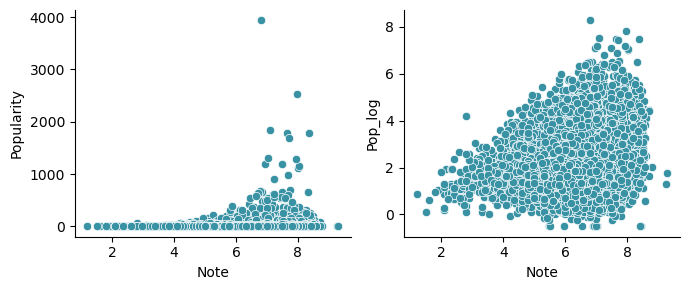

In [14]:
# Je regarde la popularité du film en fonction de la note avant et après logarithme
fig, axs = plt.subplots(1,2, figsize=(7,3))
Notes = ['Popularity', 'Pop_log']
for i in range(2):
    sns.scatterplot(data=Data_Brut, x='Note', y=Notes[i], ax=axs[i], color=Colors[2])
    for spine in ['top', 'right']:
        axs[i].spines[spine].set_visible(False)
    _ = axs[i].set(xlabel='Note', ylabel=Notes[i])
    plt.tight_layout()

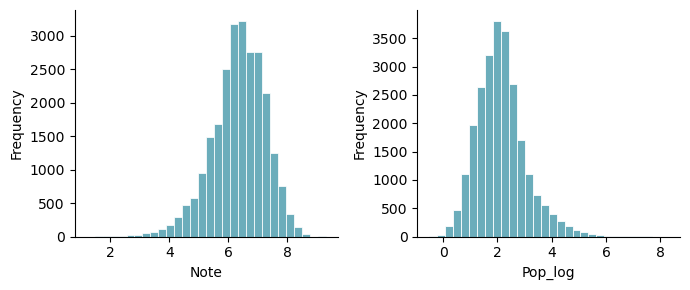

In [15]:
# Je regarde la distribution des notes et la popularité
fig, axs = plt.subplots(1,2, figsize=(7,3))
Notes = ['Note', 'Pop_log']
for i in range(2):
    sns.histplot(Data_Brut[Notes[i]], ax=axs[i], color=Colors[2], bins=30, edgecolor='w')
    for spine in ['top', 'right']:
        axs[i].spines[spine].set_visible(False)
    _ = axs[i].set(xlabel=Notes[i], ylabel='Frequency')
    plt.tight_layout()

In [16]:
# Je calcule le bénéfice réalisé par chaque film
Data_Brut.loc[Data_Brut['Budget']==0, 'Budget'] = np.nan
Data_Brut.loc[Data_Brut['Revenue']==0, 'Revenue'] = np.nan
Data_Brut['Benefice'] = ((Data_Brut['Revenue']/Data_Brut['Budget'])-1)*100

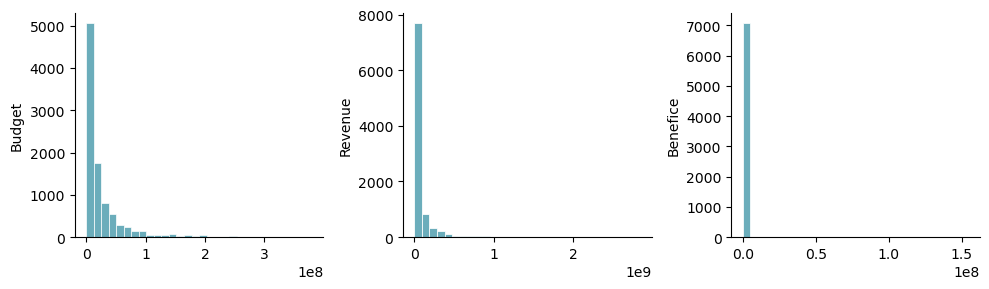

In [17]:
# Je regarde la distribution
fig, axs = plt.subplots(1,3, figsize=(10,3))
Feats = ['Budget', 'Revenue', 'Benefice']
for i in range(3):
    sns.histplot(Data_Brut[Feats[i]], ax=axs[i], color=Colors[2], bins=30, edgecolor='w')
    for spine in ['top', 'right']:
        axs[i].spines[spine].set_visible(False)
    _ = axs[i].set(xlabel='', ylabel=Feats[i])
    plt.tight_layout()

In [18]:
# Comme la distribution est fortement sur la gauche, je réalise le logarithme
for feature in ['Budget', 'Revenue', 'Benefice']:
    Data_Brut[feature+'log'] = Data_Brut[feature].apply(lambda x: np.log(x))
    Data_Brut[feature+'log'].replace([np.inf, -np.inf], np.nan, inplace=True)

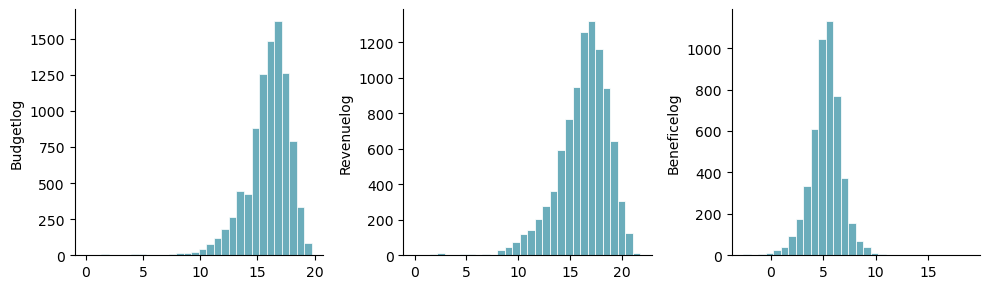

In [19]:
# Je recommence
fig, axs = plt.subplots(1,3, figsize=(10,3))
Feats = ['Budgetlog', 'Revenuelog', 'Beneficelog']
for i in range(3):
    sns.histplot(Data_Brut[Feats[i]], ax=axs[i], color=Colors[2], bins=30, edgecolor='w')
    for spine in ['top', 'right']:
        axs[i].spines[spine].set_visible(False)
    _ = axs[i].set(xlabel='', ylabel=Feats[i])
    plt.tight_layout()

In [20]:
# Je crée une variable 'rentability', en fonction des quantiles du bénéfice
Data_Brut['Beneficelog_cut'] = pd.qcut(Data_Brut['Beneficelog'], 3, labels=[1, 2, 3])
def rentability(df):
    if df['Benefice']<0:
        return(0)
    elif df['Benefice']>0:
        return(df['Beneficelog_cut'])
Data_Brut['Rentability'] = Data_Brut.apply(rentability, axis=1)
Data_Brut.drop(['Beneficelog_cut'], axis=1, inplace=True)
# 0: Pas rentable, 1,2,3 : Rentable

### Suites ?

La variable Collection a beaucoup de valeurs manquantes. Cependant elle nous renseigne si le film fait parti d'une saga. Il pourrait s'agir d'une information importante afin de déterminer si les films sont des suites ou non (ce qui pourrait avoir un impact sur la réception critique). Nous décidons donc de la garder et de créer une nouvelle colonne pour déterminer si le film est original (0) ou une suite.

In [21]:
def suite(df):
    # S'il y a des NaN, la fonction retourne 0
    if pd.isna(df['Collection']):
        return (0)
    # Sinon
    else:
        ALL_films = ast.literal_eval(df['Films_Collection']) # Transforme la chaîne de caractère en liste
        Saga = len(ALL_films) # Le nombre de film composant la saga
        ID = df['TMDb_id']
        for i in range(Saga):
            if ALL_films[i]['id'] == ID : # Récupère le numéro de suite dans la saga
                suite = i
#                 return(suite)
        if suite > 0:
            return(1)
        else:
            return(0)

In [22]:
# Crée la colonne Suite
Data_Brut['Suite'] = Data_Brut.apply(suite, axis=1)

In [23]:
def adaptation(df):
    # S'il y a des NaN, la fonction retourne 0
    if pd.isna(df['Keywords']):
        return (np.nan)
    # Sinon
    else:
        ALL_films = ast.literal_eval(df['Keywords']) # Transforme la chaîne de caractère en liste
        words = len(ALL_films) # Le nombre de film composant la saga
        adapt = 0
        for i in range(words):
            if ALL_films[i]['id'] == 818: # Si l'id est égale à 818, c'est une adaptation de livre
                adapt = 1
        return adapt

def spin_off(df):
    # S'il y a des NaN, la fonction retourne 0
    if pd.isna(df['Keywords']):
        return (np.nan)
    # Sinon
    else:
        ALL_films = ast.literal_eval(df['Keywords']) # Transforme la chaîne de caractère en liste
        words = len(ALL_films) # Le nombre de film composant la saga
        spin = 0
        for i in range(words):
            if ALL_films[i]['id'] == 15285: # Si l'id est 15285, c'est un spin-off
                spin = 1
        return spin

def reboot(df):
    # S'il y a des NaN, la fonction retourne 0
    if pd.isna(df['Keywords']):
        return (np.nan)
    # Sinon
    else:
        ALL_films = ast.literal_eval(df['Keywords']) # Transforme la chaîne de caractère en liste
        words = len(ALL_films) # Le nombre de film composant la saga
        reboot = 0
        for i in range(words):
            if ALL_films[i]['id'] == 161184: # Si l'id est 161184, c'est un reboot
                reboot = 1
        return reboot

In [24]:
# Je crée les colonnes adaptation, spin-off et reboot
Data_Brut['Adaptation'] = Data_Brut.apply(adaptation, axis=1)
Data_Brut['Spin_off'] = Data_Brut.apply(spin_off, axis=1)
Data_Brut['Reboot'] = Data_Brut.apply(reboot, axis=1)

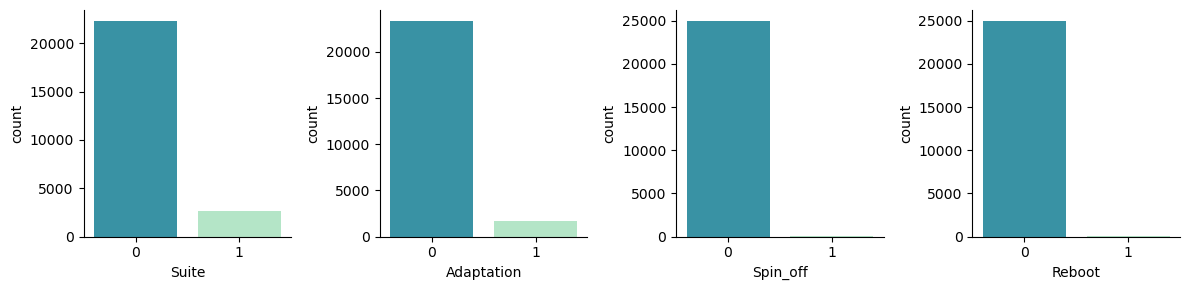

In [25]:
# Je plot les différentes variables
fig, axs = plt.subplots(1,4, figsize=(12,3))
feat = ['Suite', 'Adaptation', 'Spin_off', 'Reboot']
for i in range(4):
    sns.countplot(Data_Brut[feat[i]], palette=[Colors[2], Colors[4]], ax=axs[i], saturation=1)
    for spine in ['top', 'right']:
        axs[i].spines[spine].set_visible(False)
plt.tight_layout()

### Région ?

In [26]:
# S'il manque la valeur d'un pays, je précise que le pays est inconnu
Data_Brut.loc[Data_Brut['Pays'].isnull(), 'Pays'] = 'Inconnu'

In [27]:
# Je regroupe les pays en region pour ajouter la colonne région
Europe = ['FR', 'GB', 'IT', 'DE', 'ES', 
          'DK', 'SE', 'CH', 'BE', 'AT', 
          'HR', 'RO', 'RU', 'PL', 'FI', 
          'LU', 'RS', 'IE', 'NO', 'PT', 
          'SU', 'GR', 'HU', 'EE', 'UA', 
          'BG', 'IS', 'MK', 'CY', 'CZ', 
          'LT', 'BY']
Asia = ['JP', 'HK', 'IN', 'KR', 
        'CN', 'SG', 'TH', 'XC', 
        'ID', 'TW', 'KZ', 'PH', 
        'KP', 'BD']
Afrique = ['AE', 'ZA', 'EG', 'TN']
Orient = ['TR', 'IR', 'IL', 'PS', 'AZ', 'AM']
Oceanie = ['AU', 'NZ', 'NL']
America = ['BR', 'MX', 'AR', 'CL', 'BS', 
           'CO', 'PE', 'PR', 'CU']
US = ['US', 'CA']

def continent(pays):
    if pays in Europe:
        return 'Europe'
    elif pays in Asia:
        return 'Asie'
    elif pays in Afrique:
        return 'Afrique'
    elif pays in Orient:
        return 'Orient'
    elif pays in Oceanie:
        return 'Oceanie'
    elif pays in America:
        return 'America'
    elif pays in US:
        return 'US'
    else:
        return pays

In [28]:
Data_Brut['Region'] = Data_Brut['Pays'].map(lambda x: continent(x))

Ensuite, nous relevons l'année de sortie des films, puisque la date précise ne nous intéresse pas vraiment. Nous focaliserons notre étude sur les films sortis à partir des années 70. Nous en profitons pour créer une colonne pour récupérer la décennie. 

In [29]:
Data_Brut['Year'] = Data_Brut['Date'].map(lambda x: int(x.split('-')[0]))
Data_Brut['Year'] = Data_Brut['Year'].astype('int64')

In [30]:
# On regroupe les années par décennie
Data_Brut['Decades'] = Data_Brut['Year'].map(lambda x: np.floor(x/10)*10)
Data_Brut['Decades'] = Data_Brut['Decades'].astype('int64')

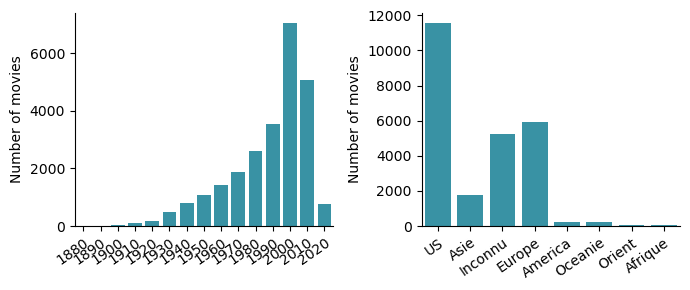

In [31]:
# On plot le nombre de film en fonction de la décennie ou de la région
fig, axs = plt.subplots(1,2, figsize=(7,3))
Feats = ['Decades', 'Region']
for i in range(2):
    sns.countplot(Data_Brut[Feats[i]], ax=axs[i], color=Colors[2], saturation=1)
    for spine in ['top', 'right']:
        axs[i].spines[spine].set_visible(False)
    _ = plt.setp(axs[i].get_xticklabels(), rotation=35, ha="right", rotation_mode="anchor")
    _ = axs[i].set(xlabel='', ylabel='Number of movies')
    plt.tight_layout()

### Les genres de films

In [32]:
# Je récupère la liste de catégories auxquelles appartiennent les films
def split_genres(genre):
    genres = ast.literal_eval(genre)
    if genres:
        list_genres = [genres[x]['name'] for x in range(len(genres))]
        return(list_genres)
    else:
        return ([])

In [33]:
Data_Brut['Genre'] = Data_Brut['Genre'].apply(lambda x: split_genres(x))

Certains genres n'ont pas vraiment leur place dans notre étude, tels que les documentaires. Je récupère ensuite le genre principal du film. Par exemple Fast & Furious 7 est renseigné comme Action, Thriller ; je considère donc que son genre principal est action.

In [34]:
# Liste des genres que nous ne souhaitons pas garder
Nope = ['Documentary', 'TV Movie', 'Animation', 'Family']
def split_genres_modif(df):
    genres = df['Genre']
    if len(genres)>0:
        if any([g in Nope for g in genres]):
            return np.nan
        # Les films de western et de guerre sont des thèmes forts donc je considère 
        # qu'ils prévalent sur les autres catégories
        elif any([g in ['Western'] for g in genres]):  
            return 'Western'
        elif any([g in ['War'] for g in genres]):
            return 'War'
        elif genres[0]=='Mystery':
            return 'Thriller'
        elif genres[0]=='Science Fiction':
            return 'Sci-Fi'
        elif any([g in ['Comedy'] for g in genres]) and any([g in ['Romance'] for g in genres]):
            return 'Rom-Com' 
        elif (len(genres)==1) & (genres[0]=='Music'):
            return np.nan
        else:
            return genres[0]
    else:
        return np.nan

In [35]:
# Nous rajoutons une colonne avec le genre principal du film
Data_Brut['Genre_Principal'] = Data_Brut.apply(split_genres_modif, axis=1)
Data_Brut.sample(1)

,TMDb_id,IMDB_id,Titre,Genre,Date,Pays,Runtime,Cast,Crew,Budget,...,Beneficelog,Rentability,Suite,Adaptation,Spin_off,Reboot,Region,Year,Decades,Genre_Principal
2415,9894,0115798,The Cable Guy,"[Comedy, Drama, Thriller]",1996-06-10,US,96,"[{'adult': False, 'gender': 2, 'id': 206, 'kno...","[{'adult': False, 'gender': 2, 'id': 1298, 'kn...",47000000.0,...,4.777259,1.0,0,0,0,0,US,1996,1990,Comedy


Enfin, selon une étude certains genres de films sont préférentiellement regardé par les hommes, par les femmes ou sans préférences. Nous ajoutons donc une colonne pour préciser dans quel cas se situe le genre. 

In [36]:
# Enfin je crée une colonne pour la préférence de genre, selon l'étude de Wühr en 2017
Hommes = ['Action', 'Adventure', 'Horror', 'Sci-Fi', 'Fantasy', 'War', 'Western']
Femmes = ['Drama', 'Romance', 'Rom-Com', 'Music']
Neutre = ['Comedy', 'Thriller', 'Crime', 'History']
def genre_pref(genre):
    if genre in Hommes:
        return 'Men'
    elif genre in Femmes:
        return 'Women'
    elif genre in Neutre:
        return 'Neutral'
    else:
        return genre
Data_Brut['Preference'] = Data_Brut['Genre_Principal'].map(lambda x: genre_pref(x))

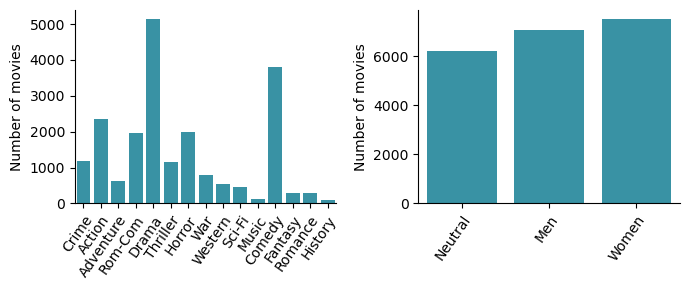

In [37]:
# Je plot le nombre de film selon les catégories principales et la préférence de genre
fig, axs = plt.subplots(1,2, figsize=(7,3))
Feats = ['Genre_Principal', 'Preference']
for i in range(2):
    sns.countplot(Data_Brut[Feats[i]], ax=axs[i], color=Colors[2], saturation=1)
    for spine in ['top', 'right']:
        axs[i].spines[spine].set_visible(False)
    _ = plt.setp(axs[i].get_xticklabels(), rotation=55, ha="right", rotation_mode="anchor")
    _ = axs[i].set(xlabel='', ylabel='Number of movies')
    plt.tight_layout()

### Extraction des données sur la représentation des femmes
La prochaine étape est de récupérer des informations concernant le genre des acteurs principaux de ces films et de la réalisation. Nous faisons le choix de ne garder que les 5 premiers rôles principaux. Nous récupérons également la popularité des personnes. Celle-ci est calculé par le site TMDb en fonction des vues reçues.

In [38]:
# Je récupère le genre du réalisateur, ainsi que sa popularité
genres = ['UN', 'Female', 'Male', 'Non-Binary']
def genre_real(df):
    Crew = ast.literal_eval(df['Crew'])
    for i in range(len(Crew)):
        if Crew[i]['job'] == 'Director':
            return (genres[Crew[i]['gender']], Crew[i]['popularity'])

In [39]:
Data_Brut['Genre_Direct'], Data_Brut['Pop_Direct'] = Data_Brut.apply(genre_real, axis=1, result_type='expand').T.values
Data_Brut['Pop_Direct'] = Data_Brut['Pop_Direct'].astype('float64')
Data_Brut.sample(1)

,TMDb_id,IMDB_id,Titre,Genre,Date,Pays,Runtime,Cast,Crew,Budget,...,Adaptation,Spin_off,Reboot,Region,Year,Decades,Genre_Principal,Preference,Genre_Direct,Pop_Direct
21487,48336,0113718,Lumière and Company,"[Action, Drama, Comedy, Documentary]",1995-12-20,FR,88,"[{'adult': False, 'gender': 0, 'id': 932360, '...","[{'adult': False, 'gender': 2, 'id': 27436, 'k...",NaN,...,0,0,0,Europe,1995,1990,NaN,NaN,Male,3.458


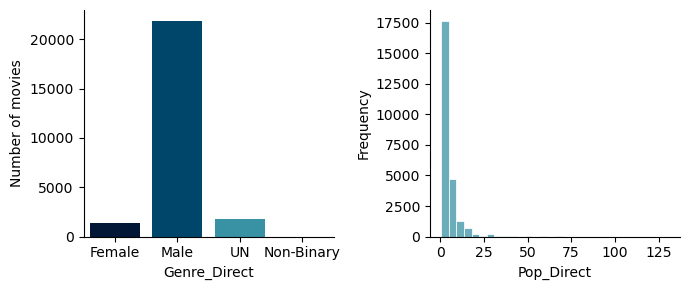

In [40]:
fig, axs = plt.subplots(1,2, figsize=(7,3))

sns.countplot(Data_Brut['Genre_Direct'], ax=axs[0], palette=Colors, saturation=1)
sns.histplot(Data_Brut['Pop_Direct'], ax=axs[1], color=Colors[2], bins=30, edgecolor='w')

for spine in ['top', 'right']:
    axs[0].spines[spine].set_visible(False)
    axs[1].spines[spine].set_visible(False)
axs[0].set(ylabel='Number of movies')
axs[1].set(ylabel='Frequency')
plt.tight_layout()

In [41]:
def actress(df):
    Cast = ast.literal_eval(df['Cast'])
    taille = len(Cast) # Je récupère la taille du casting
    if Cast:
        if taille > 5:
            Cast = Cast[:5]
        Cast_genres = [x['gender'] for x in Cast]
        Cast_pop = [x['popularity'] for x in Cast]
        First_role = Cast_genres[0] # Le genre du premier rôle
        if 1 in Cast_genres:
            First_woman = -Cast_genres.index(1)+len(Cast) # L'importance du premier rôle féminin
            Ratio = Cast_genres.count(1)/len(Cast) # Le ratio de femme sur les 5 premiers personnages
            return (taille, genres[First_role], Cast_pop[0], Ratio, First_woman, Cast_pop[Cast_genres.index(1)])
        else:
            First_woman = 0
            Ratio = 0
            return (taille, genres[First_role], Cast_pop[0], Ratio, First_woman, 0)

In [42]:
(Data_Brut['Taille_Cast'], Data_Brut['First_Role'], 
 Data_Brut['Pop_First_Role'], Data_Brut['Ratio'], 
 Data_Brut['Role_First_Woman'], Data_Brut['Pop_First_Woman']
) = Data_Brut.apply(actress, axis=1, result_type='expand').T.values

# Je récupère également la popularité du premier rôle et du premier rôle féminin
Data_Brut['Pop_First_Role'] = Data_Brut['Pop_First_Role'].astype('float64') 

Data_Brut['Pop_First_Woman'] = Data_Brut['Pop_First_Woman'].astype('float64')
Data_Brut.sample(1)

,TMDb_id,IMDB_id,Titre,Genre,Date,Pays,Runtime,Cast,Crew,Budget,...,Genre_Principal,Preference,Genre_Direct,Pop_Direct,Taille_Cast,First_Role,Pop_First_Role,Ratio,Role_First_Woman,Pop_First_Woman
18368,36569,0902967,The Crimson Wing: Mystery of the Flamingos,[Documentary],2008-12-17,FR,78,"[{'adult': False, 'gender': 1, 'id': 1218994, ...","[{'adult': False, 'gender': 2, 'id': 21378, 'k...",NaN,...,NaN,NaN,Male,0.6,3.0,Female,2.135,1.0,3.0,2.135


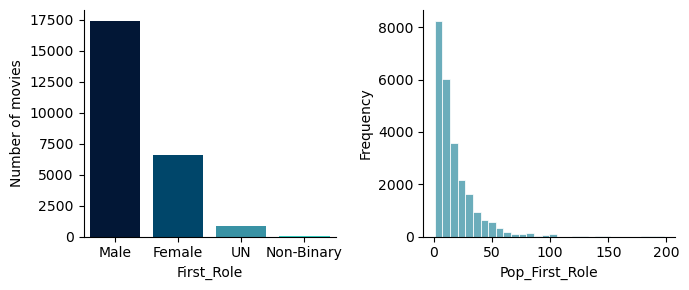

In [43]:
fig, axs = plt.subplots(1,2, figsize=(7,3))

sns.countplot(Data_Brut['First_Role'], ax=axs[0], palette=Colors, saturation=1)
sns.histplot(Data_Brut['Pop_First_Role'], ax=axs[1], color=Colors[2], bins=30, edgecolor='w')

for spine in ['top', 'right']:
    axs[0].spines[spine].set_visible(False)
    axs[1].spines[spine].set_visible(False)
axs[0].set(ylabel='Number of movies')
axs[1].set(ylabel='Frequency')
plt.tight_layout()

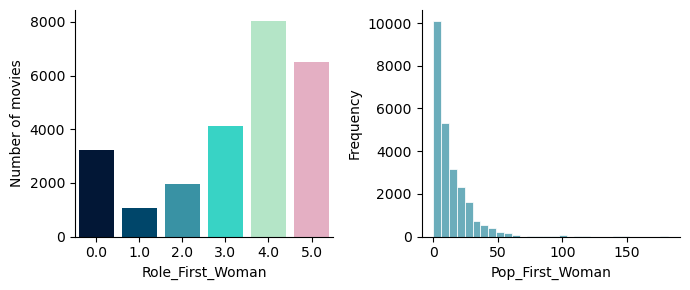

In [44]:
fig, axs = plt.subplots(1,2, figsize=(7,3))

sns.countplot(Data_Brut['Role_First_Woman'], ax=axs[0], palette=Colors, saturation=1)
sns.histplot(Data_Brut['Pop_First_Woman'], ax=axs[1], color=Colors[2], bins=30, edgecolor='w')

for spine in ['top', 'right']:
    axs[0].spines[spine].set_visible(False)
    axs[1].spines[spine].set_visible(False)
axs[0].set(ylabel='Number of movies')
axs[1].set(ylabel='Frequency')
plt.tight_layout()

In [45]:
# Comme pour la popularité des films, je fais le logarithme sur la popularité des personnes
for feature in ['Pop_Direct', 'Pop_First_Role', 'Pop_First_Woman']:
    Data_Brut[feature+'_log'] = Data_Brut[feature].apply(lambda x: np.log(x))
    Data_Brut[feature+'_log'].replace([np.inf, -np.inf], np.nan, inplace=True)

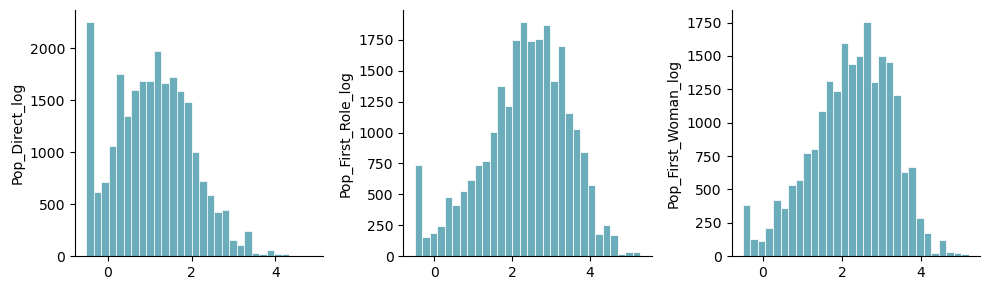

In [46]:
fig, axs = plt.subplots(1,3, figsize=(10,3))
Feats = ['Pop_Direct_log', 'Pop_First_Role_log', 'Pop_First_Woman_log']
for i in range(3):
    sns.histplot(Data_Brut[Feats[i]], ax=axs[i], color=Colors[2], bins=30, edgecolor='w')
    for spine in ['top', 'right']:
        axs[i].spines[spine].set_visible(False)
    _ = axs[i].set(xlabel='', ylabel=Feats[i])
    plt.tight_layout()

In [47]:
# Pour finir je récupère l'âge du premier rôle masculin et féminin à la sortie du film
def cast_age(df):
    Cast = ast.literal_eval(df['Cast'])
    if Cast:
        if len(Cast) > 5:
            Cast = Cast[:5]
        Cast_genres = [x['gender'] for x in Cast]
        Cast_id = [x['id'] for x in Cast]
        Age_Released_Man = 0
        Age_Released_Woman = 0
        Ages = [Age_Released_Man, Age_Released_Woman]
        if 2 in Cast_genres:
            First_man = Cast_id[Cast_genres.index(2)]
            if First_man in Births.index:
                Ages[0] = df['Year'] - Births.loc[First_man].Birth
        if 1 in Cast_genres:
            First_woman = Cast_id[Cast_genres.index(1)]
            if First_woman in Births.index:
                Ages[1] = df['Year'] - Births.loc[First_woman].Birth
        
        for age in range(len(Ages)):
            if Ages[age]==0:
                Ages[age] = np.nan
                
        return (Ages[0], Ages[1])
    else:
        return (np.nan, np.nan)

In [48]:
(Data_Brut['First_Man_Age'], Data_Brut['First_Woman_Age']) = Data_Brut.apply(cast_age, axis=1, result_type='expand').T.values

In [49]:
Data_Brut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25022 entries, 0 to 25021
Data columns (total 47 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   TMDb_id              25022 non-null  int64  
 1   IMDB_id              25022 non-null  object 
 2   Titre                25022 non-null  object 
 3   Genre                25022 non-null  object 
 4   Date                 25022 non-null  object 
 5   Pays                 25022 non-null  object 
 6   Runtime              25022 non-null  int64  
 7   Cast                 25022 non-null  object 
 8   Crew                 25022 non-null  object 
 9   Budget               9388 non-null   float64
 10  Revenue              9394 non-null   float64
 11  Popularity           25022 non-null  float64
 12  Note                 25022 non-null  float64
 13  Nb_notes             25022 non-null  int64  
 14  Collection           4527 non-null   object 
 15  Films_Collection     4527 non-null  

La dernière étape de notre petit nettoyage de données est de récupérer les films sortis après les années 60, de changer le type de certaines variables et de supprimer les lignes où le genre principal du film n'est pas renseigné (correspondant aux documentaires notamment). Nous pouvons voir qu'il manque également des valeurs pour les acteurs, nous supprimons donc également ces lignes.

In [50]:
Movies = Data_Brut.loc[(Data_Brut['Year']>= 1970) & (Data_Brut['Nb_notes']>50)].copy()
Movies = Movies.dropna(subset=['Genre_Principal'])
Movies = Movies.dropna(subset=['First_Role'])
Movies = Movies.dropna(subset=['Genre_Direct'])
Movies = Movies.dropna(subset=['Rentability'])

Movies['Role_First_Woman'] = Movies['Role_First_Woman'].astype('int64')
Movies['Ratio'] = Movies['Ratio'].astype('float64')
Movies['Rentability'] = Movies['Rentability'].astype('int64')
Movies['Taille_Cast'] = Movies['Taille_Cast'].astype('int64')

In [51]:
Movies.drop(['TMDb_id', 'IMDB_id', 'Titre', 'Date', 
             'Pays', 'Cast', 'Crew', 
             'Collection', 'Films_Collection', 
             'Keywords', 'Poster', 'Year',
             'Benefice', 'Beneficelog', 
             'Pop_Direct', 'Pop_Direct_log', 'Popularity', 'Pop_log', 
             'Pop_First_Role', 'Pop_First_Role_log', 
             'Pop_First_Woman', 'Pop_First_Woman_log'], axis=1, inplace=True)

## Exploration des données
Maintenant que les données brut ont été nettoyées, nous allons pouvoir récupérer un dataframe propre afin de commencer l'exploration des données.

In [52]:
Movies_Clean = Movies.loc[(Movies['First_Role']=='Male') | (Movies['First_Role']=='Female')].copy()
Movies_Clean['First_Role'] = pd.get_dummies(Movies_Clean['First_Role'])['Female']
Movies_Clean['Direct_Woman'] = pd.get_dummies(Movies_Clean['Genre_Direct'])['Female']
Movies_Clean.drop(['Genre_Direct'],axis=1,inplace=True)

In [53]:
Movies_Clean.sample(3)

,Genre,Runtime,Budget,Revenue,Note,Nb_notes,Bechdel,Budgetlog,Revenuelog,Rentability,...,Decades,Genre_Principal,Preference,Taille_Cast,First_Role,Ratio,Role_First_Woman,First_Man_Age,First_Woman_Age,Direct_Woman
9099,"[Western, Drama, Action]",100,8000000.0,1561698.0,5.885,235,NaN,15.894952,14.261284,0,...,2010,Western,Men,45,0,0.2,2,49.0,27.0,0
4595,"[Comedy, Horror, Romance]",94,3200000.0,10000000.0,5.772,224,NaN,14.978661,16.118096,2,...,1980,Rom-Com,Women,20,0,0.4,4,23.0,42.0,0
2208,[Horror],122,11000000.0,441306145.0,7.713,6492,3.0,16.213406,19.905249,3,...,1970,Horror,Men,42,1,0.4,5,NaN,41.0,0


In [54]:
Movies_Clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5468 entries, 0 to 25016
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Genre             5468 non-null   object 
 1   Runtime           5468 non-null   int64  
 2   Budget            5468 non-null   float64
 3   Revenue           5468 non-null   float64
 4   Note              5468 non-null   float64
 5   Nb_notes          5468 non-null   int64  
 6   Bechdel           3307 non-null   float64
 7   Budgetlog         5468 non-null   float64
 8   Revenuelog        5468 non-null   float64
 9   Rentability       5468 non-null   int64  
 10  Suite             5468 non-null   int64  
 11  Adaptation        5468 non-null   int64  
 12  Spin_off          5468 non-null   int64  
 13  Reboot            5468 non-null   int64  
 14  Region            5468 non-null   object 
 15  Decades           5468 non-null   int64  
 16  Genre_Principal   5468 non-null   object 

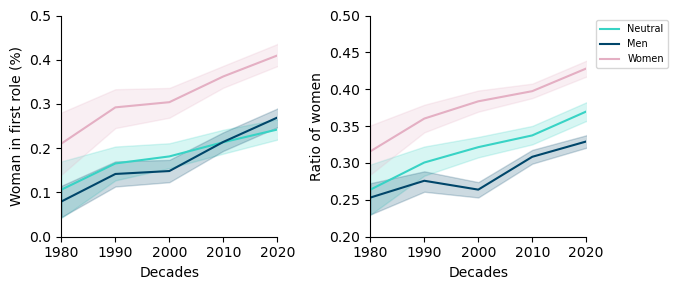

In [55]:
# Premier rôle féminin en fonction des décennies dans les films "masculins", "féminins" et "neutres"
fig, axs = plt.subplots(1,2, figsize=(7,3))
sns.lineplot(data=Movies_Clean, x='Decades', y='First_Role', hue='Preference', 
             palette=[Colors[3], Colors[1], Colors[5]], ax=axs[0], ci=80)
sns.lineplot(data=Movies_Clean, x='Decades', y='Ratio', hue='Preference', 
             palette=[Colors[3], Colors[1], Colors[5]], ax=axs[1], ci=80)

axs[0].set(ylim=[0, 0.5], xlim=[1970, 2010], xticklabels=['1980', '1990', '2000', '2010', '2020'],
           ylabel='Woman in first role (%)')
axs[0].get_legend().remove()
axs[1].set(ylim=[0.2, 0.5], xlim=[1970, 2010], xticklabels=['1980', '1990', '2000', '2010', '2020'], 
           ylabel='Ratio of women')
axs[1].legend(bbox_to_anchor=(0, 1, 1.4, 0), prop={'size': 7})

for spine in ['top', 'right']:
        axs[0].spines[spine].set_visible(False)
        axs[1].spines[spine].set_visible(False)
plt.tight_layout()
plt.savefig('First Roles over decades.png')

In [56]:
# Je décomposes mon dataset en 3 pour faire des graphs par préférence
Movies_Comparison = Movies_Clean.copy()
Movies_Comparison.loc[Movies_Comparison['Decades']<=1990, 'Decades'] = 1990

Pref_men = Movies_Comparison.loc[Movies_Comparison['Preference']=='Men'].copy()
Pref_neutral = Movies_Comparison.loc[Movies_Comparison['Preference']=='Neutral'].copy()
Pref_women = Movies_Comparison.loc[Movies_Comparison['Preference']=='Women'].copy()
DFs = [Pref_men, Pref_neutral, Pref_women]

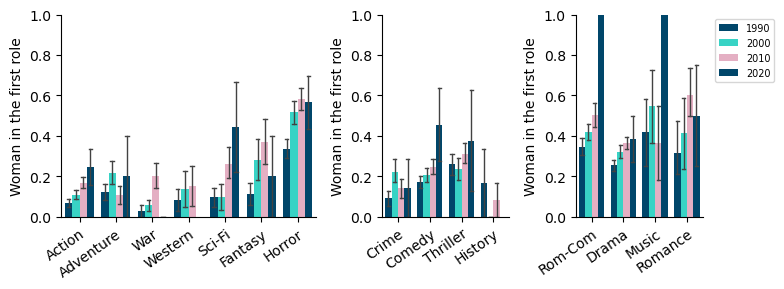

In [57]:
# Nombre de premier rôle féminin dans les différentes catégories de film
fig, axs = plt.subplots(1,3, figsize=(8,3), gridspec_kw={'width_ratios': [4, 2, 2]})
for col in range(3):    
    sns.barplot(data=DFs[col], x='Genre_Principal', y='First_Role', hue='Decades', 
                palette=[Colors[1], Colors[3], Colors[5]], saturation=1, 
                ax=axs[col], errwidth=1, capsize=0.1, ci=80)
    axs[col].set(xlabel='', ylim=[0,1], ylabel='Woman in the first role')
    axs[col].get_legend().remove()
    for spine in ['top', 'right']:
        axs[col].spines[spine].set_visible(False)
    plt.setp(axs[col].get_xticklabels(), rotation=35, ha="right", rotation_mode="anchor")
    
axs[2].legend(prop={'size': 7}, bbox_to_anchor=(0, 1, 1.6, 0))
plt.tight_layout()
plt.savefig('First Roles in genres.png')

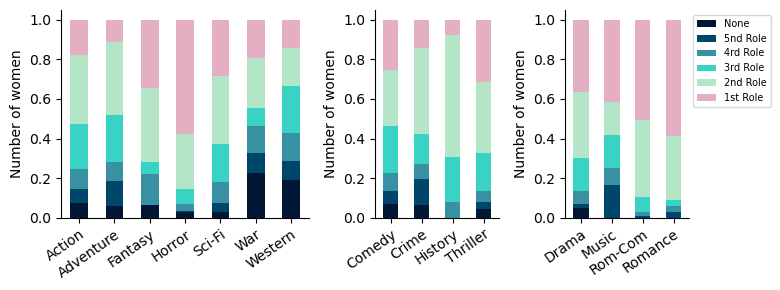

In [58]:
# Importance du première rôle féminin dans les différentes catégories de films
fig, axs = plt.subplots(1,3, figsize=(8,3), gridspec_kw={'width_ratios': [4, 2, 2]})
for col in range(3):  
    
    Number_Woman = (DFs[col].loc[DFs[col]['Decades']>=2010][['Genre_Principal','Role_First_Woman']]
                    .groupby(['Genre_Principal'])
                    .value_counts(normalize=True))
    Number_Woman.unstack().plot.bar(stacked=True, ax=axs[col], color=Colors)
    axs[col].set(xlabel='', ylabel='Number of women')
    axs[col].get_legend().remove()
    for spine in ['top', 'right']:
        axs[col].spines[spine].set_visible(False)
    plt.setp(axs[col].get_xticklabels(), rotation=35, ha="right", rotation_mode="anchor")
    
h,l = axs[0].get_legend_handles_labels()
axs[2].legend(h[:6], ['None', '5nd Role', '4rd Role', '3rd Role', '2nd Role', '1st Role'], 
              loc='upper right', prop={'size': 7}, bbox_to_anchor=(0, 1, 1.7, 0))
plt.tight_layout()
plt.savefig('Ratio in genres 2010.png')

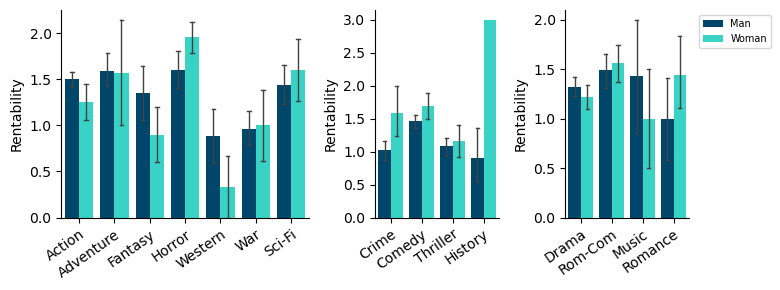

In [59]:
fig, axs = plt.subplots(1,3, figsize=(8,3), gridspec_kw={'width_ratios': [4, 2, 2]})
for col in range(3):    
    sns.barplot(data=DFs[col].loc[DFs[col]['Decades']==2010], x='Genre_Principal', y='Rentability', hue='First_Role', 
                palette=[Colors[1], Colors[3], Colors[5]], saturation=1,
                ax=axs[col], errwidth=1, capsize=0.1, ci=80)
    axs[col].set(xlabel='', ylabel='Rentability')
    axs[col].get_legend().remove()
    for spine in ['top', 'right']:
        axs[col].spines[spine].set_visible(False)
    plt.setp(axs[col].get_xticklabels(), rotation=35, ha="right", rotation_mode="anchor")

h,l = axs[0].get_legend_handles_labels()
axs[2].legend(h[:2], ['Man', 'Woman'], 
              prop={'size': 7}, bbox_to_anchor=(0, 1, 1.7, 0))
plt.tight_layout()
plt.savefig('Rentability in genres.png')

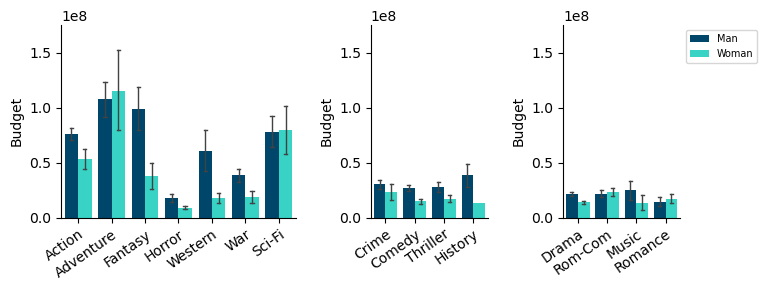

In [60]:
fig, axs = plt.subplots(1,3, figsize=(8,3), gridspec_kw={'width_ratios': [4, 2, 2]})
for col in range(3):    
    sns.barplot(data=DFs[col].loc[DFs[col]['Decades']==2010], x='Genre_Principal', y='Budget', hue='First_Role', 
                palette=[Colors[1], Colors[3], Colors[5]], saturation=1,
                ax=axs[col], errwidth=1, capsize=0.1, ci=80)
    axs[col].set(xlabel='', ylim=[0, 1.75e8], ylabel='Budget')
    axs[col].get_legend().remove()
    for spine in ['top', 'right']:
        axs[col].spines[spine].set_visible(False)
    plt.setp(axs[col].get_xticklabels(), rotation=35, ha="right", rotation_mode="anchor")

h,l = axs[0].get_legend_handles_labels()
axs[2].legend(h[:2], ['Man', 'Woman'], 
              prop={'size': 7}, bbox_to_anchor=(0, 1, 1.7, 0))
plt.tight_layout()
plt.savefig('Budget in genres.png')

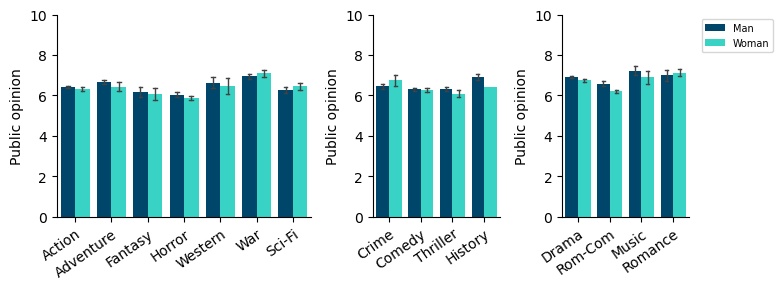

In [61]:
fig, axs = plt.subplots(1,3, figsize=(8,3), gridspec_kw={'width_ratios': [4, 2, 2]})
for col in range(3):    
    sns.barplot(data=DFs[col].loc[DFs[col]['Decades']==2010], x='Genre_Principal', y='Note', hue='First_Role', 
                palette=[Colors[1], Colors[3], Colors[5]], saturation=1,
                ax=axs[col], errwidth=1, capsize=0.1, ci=80)
    axs[col].set(xlabel='', ylim=[0,10], ylabel='Public opinion')
    axs[col].get_legend().remove()
    for spine in ['top', 'right']:
        axs[col].spines[spine].set_visible(False)
    plt.setp(axs[col].get_xticklabels(), rotation=35, ha="right", rotation_mode="anchor")

h,l = axs[0].get_legend_handles_labels()
axs[2].legend(h[:2], ['Man', 'Woman'], 
              prop={'size': 7}, bbox_to_anchor=(0, 1, 1.7, 0))
plt.tight_layout()
plt.savefig('Opinion in genres.png')

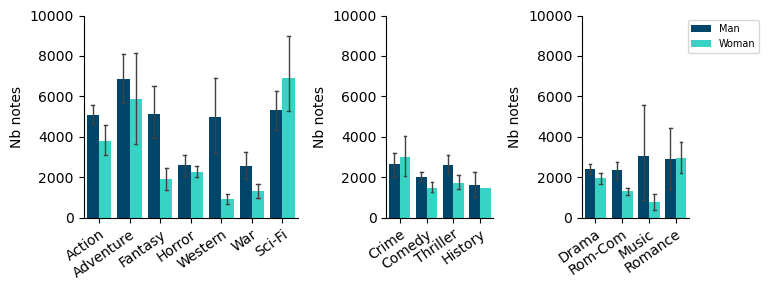

In [62]:
fig, axs = plt.subplots(1,3, figsize=(8,3), gridspec_kw={'width_ratios': [4, 2, 2]})
for col in range(3):    
    sns.barplot(data=DFs[col].loc[DFs[col]['Decades']==2010], x='Genre_Principal', y='Nb_notes', hue='First_Role', 
                palette=[Colors[1], Colors[3], Colors[5]], saturation=1,
                ax=axs[col], errwidth=1, capsize=0.1, ci=80)
    axs[col].set(xlabel='', ylabel='Nb notes', ylim=[0, 10000])
    axs[col].get_legend().remove()
    for spine in ['top', 'right']:
        axs[col].spines[spine].set_visible(False)
    plt.setp(axs[col].get_xticklabels(), rotation=35, ha="right", rotation_mode="anchor")

h,l = axs[0].get_legend_handles_labels()
axs[2].legend(h[:2], ['Man', 'Woman'], 
              prop={'size': 7}, bbox_to_anchor=(0, 1, 1.7, 0))
plt.tight_layout()
plt.savefig('Nb notes in genres.png')

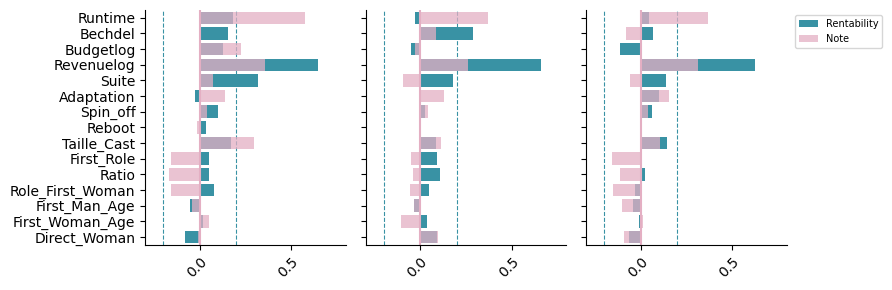

In [63]:
# Corrélations de la rentabilité et de la note avec les autres variables sur tout le dataset
fig, axs = plt.subplots(1,3, figsize=(9,3), sharey=True)

for col in range(3):
    # Je récupère les corrélations entre la note et les autres variables
    corr_data = DFs[col].loc[DFs[col]['Decades']==2010].corr().drop(['Rentability',
                                                                     'Revenue', 'Nb_notes', 
                                                                     'Decades', 'Budget', 
                                                                     'Revenue', 'Note'], axis=0)
    sns.barplot(y=corr_data.index, x=corr_data['Rentability'], ax=axs[col], 
                color=Colors[2], zorder=2, label='Rentability', saturation=1, orient='h')
    sns.barplot(y=corr_data.index, x=corr_data['Note'], ax=axs[col], 
                color=Colors[5], alpha=0.75, zorder=2, label='Popularity', saturation=1, orient='h')
    axs[col].set(xlabel='', xlim=[-0.3, 0.8])
    axs[col].axvline(0, color=Colors[5])
    for corr in [-0.2, 0.2]:
        axs[col].axvline(corr, color=Colors[2], linestyle='--', linewidth=0.8, zorder=1)
    for spine in ['top', 'right']:
        axs[col].spines[spine].set_visible(False)
    h,l = axs[0].get_legend_handles_labels()
    axs[2].legend(h[:2], ['Rentability', 'Note'], 
          prop={'size': 7}, bbox_to_anchor=(0, 1, 1.5, 0))
    plt.setp(axs[col].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.tight_layout()
plt.savefig(f'Correlation_Preference.png')

In [64]:
Data2010 = Movies_Comparison[Movies_Comparison['Decades']>=2010]
Data2010.drop(['Decades'], 
              axis=1, inplace=True)

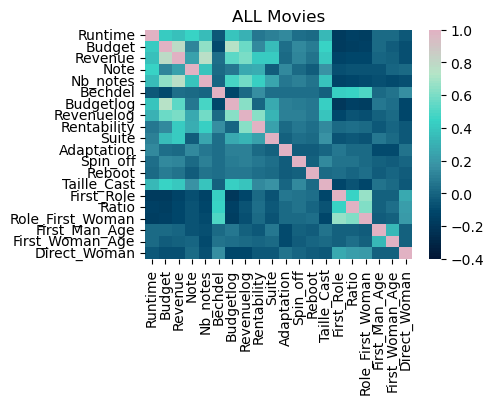

In [65]:
plt.figure(figsize=(5,4))
sns.heatmap(Data2010.corr(), cmap=Gradient, vmin=-0.4)
plt.tight_layout()
plt.title('ALL Movies')
plt.savefig(f'Heatmap_ALL.png')

In [66]:
# Je récupère uniquement les variables "objectives" pour le clustering
Features_Brut = Data2010.drop(['Genre', 'Rentability', 'Revenuelog', 'Bechdel', 'Region', 
                               'Note', 'Revenue', 'Budgetlog', 'Genre_Principal', 
                               'Preference', 'First_Man_Age', 'First_Woman_Age'], axis=1).copy()

In [67]:
# Je dummise ma liste de catégorie que je rajoute à mon dataset pré-clustering
genres = []
for row in Data2010['Genre']:
    row = [genre.strip() for genre in row]
    for genre in row:
        if genre not in genres:
            genres.append(genre)
for genre in genres:
    Features_Brut[genre] = Data2010['Genre'].map(set([genre]).issubset).astype(int)

In [68]:
Features_Brut.columns

Index(['Runtime', 'Budget', 'Nb_notes', 'Suite', 'Adaptation', 'Spin_off',
       'Reboot', 'Taille_Cast', 'First_Role', 'Ratio', 'Role_First_Woman',
       'Direct_Woman', 'Crime', 'Action', 'Thriller', 'Adventure',
       'Science Fiction', 'Fantasy', 'Comedy', 'Drama', 'Mystery', 'Romance',
       'Horror', 'Western', 'History', 'War', 'Music'],
      dtype='object')

In [69]:
Features_Brut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1901 entries, 123 to 25016
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Runtime           1901 non-null   int64  
 1   Budget            1901 non-null   float64
 2   Nb_notes          1901 non-null   int64  
 3   Suite             1901 non-null   int64  
 4   Adaptation        1901 non-null   int64  
 5   Spin_off          1901 non-null   int64  
 6   Reboot            1901 non-null   int64  
 7   Taille_Cast       1901 non-null   int64  
 8   First_Role        1901 non-null   uint8  
 9   Ratio             1901 non-null   float64
 10  Role_First_Woman  1901 non-null   int64  
 11  Direct_Woman      1901 non-null   uint8  
 12  Crime             1901 non-null   int32  
 13  Action            1901 non-null   int32  
 14  Thriller          1901 non-null   int32  
 15  Adventure         1901 non-null   int32  
 16  Science Fiction   1901 non-null   int32

# Clustering
Modèle de prédiction de la réception du public (soit basée sur la note, soit sur la rentabilité du film).

In [70]:
# Transformation numérique, on applique un scaler sur les valeurs numériques
num_transf = StandardScaler()
num_col = make_column_selector(dtype_include=['float64', 'int64'])

# Transformation catégorie, on encode les colonnes catégorielles
cat_transf = OneHotEncoder()
cat_col = make_column_selector(dtype_include=['object', 'category'])

transfo_feature = make_column_transformer((num_transf, num_col), 
                                          (cat_transf, cat_col), 
                                          remainder = 'passthrough', 
                                          verbose_feature_names_out = False)

# Pipeline avec le preprocessing (transformation des colonnes) puis le kmeans
preprocessor = Pipeline([("transfo", transfo_feature)
                        ])
pipe = Pipeline([('preprocessor', preprocessor), 
                 ('kmeans', KMeans(n_clusters=6, random_state=87, max_iter=1500))
                ])

In [71]:
# Je récupère les valeurs de SSE et de silhouette pour déterminer le nombre de clusters
sse = []
silhouette = []
for k in range(1, 50):
    pipe['kmeans'].n_clusters=k
    pipe.fit(Features_Brut)
    sse.append(pipe['kmeans'].inertia_)
    if k>1:
        silhouette.append(silhouette_score(pipe['preprocessor'].transform(Features_Brut), 
                                           pipe['kmeans'].labels_))
Knee = KneeLocator(range(1,50), sse, curve="convex", direction="decreasing").elbow
ind = np.where(silhouette==np.max(silhouette[2:]))[0][0]+2

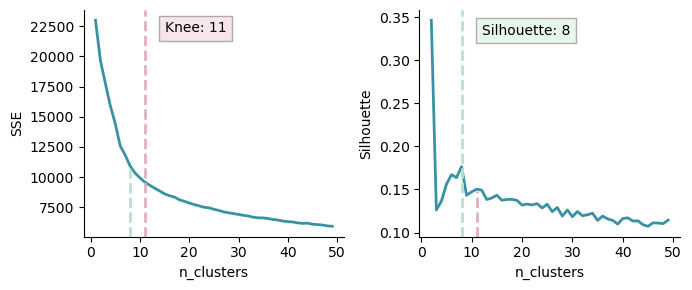

In [72]:
# Je plot le SSE et le score de silhouette
fig, axs = plt.subplots(1,2, figsize=(7,3))
sns.lineplot(x=range(1,50), y=sse, ax=axs[0], color=Colors[2], linewidth=2)
sns.lineplot(x=range(2,50), y=silhouette, ax=axs[1], color=Colors[2], linewidth=2)
for spine in ['top', 'right']:
    axs[0].spines[spine].set_visible(False)
    axs[1].spines[spine].set_visible(False)
    
_ = axs[0].set(xlabel='n_clusters', ylabel='SSE')
_ = axs[0].axvline(x=Knee, color=Colors[5], linestyle='--', linewidth=2)
_ = axs[0].axvline(x=ind, ymax=0.3, color=Colors[4], linestyle='--', linewidth=2)
_ = axs[0].text(x=Knee+4, y=22000, 
                s=f'Knee: {Knee}', 
                bbox=dict(facecolor=Colors[5], alpha=0.3))

_ = axs[1].set(xlabel='n_clusters', ylabel='Silhouette')
_ = axs[1].axvline(x=ind, color=Colors[4], linestyle='--', linewidth=2)
_ = axs[1].axvline(x=Knee, ymax=0.2, color=Colors[5], linestyle='--', linewidth=2)
_ = axs[1].text(x=ind+4, y=0.33, 
                s=f'Silhouette: {ind}', 
                bbox=dict(facecolor=Colors[4], alpha=0.3))

plt.tight_layout()
plt.savefig('Nombre clusters.png')

In [73]:
# Je crée un dataset où je rajoute les variables précédemment retirées
Data_Clusters = Features_Brut.copy()
pipe['kmeans'].n_clusters=Knee
pipe.fit(Features_Brut)
Data_Clusters['Genre_Principal'] = Data2010['Genre_Principal']
Data_Clusters.drop(genres, axis=1, inplace=True)
Data_Clusters['Preference'] = Data2010['Preference']
Data_Clusters['Bechdel'] = Data2010['Bechdel']
Data_Clusters['First_Man_Age'] = Data2010['First_Man_Age']
Data_Clusters['First_Woman_Age'] = Data2010['First_Woman_Age']
Data_Clusters['Note'] = Data2010['Note']
Data_Clusters['Revenue'] = Data2010['Revenue']
Data_Clusters['Rentability'] = Data2010['Rentability']
Data_Clusters['clusters'] = pipe['kmeans'].labels_
Data_Clusters.sample(2)

,Runtime,Budget,Nb_notes,Suite,Adaptation,Spin_off,Reboot,Taille_Cast,First_Role,Ratio,...,Direct_Woman,Genre_Principal,Preference,Bechdel,First_Man_Age,First_Woman_Age,Note,Revenue,Rentability,clusters
5596,84,1500000.0,216,0,0,0,0,25,0,0.0,...,0,Action,Men,NaN,29.0,NaN,6.222,8786756.0,3,8
11884,100,10000000.0,100,0,0,0,0,11,0,0.6,...,0,Drama,Women,NaN,47.0,34.0,5.900,55089.0,0,5


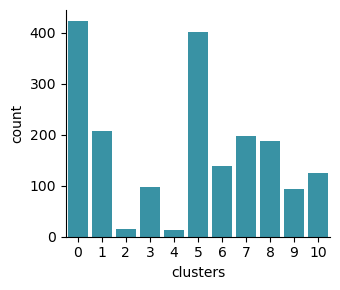

In [74]:
plt.figure(figsize=(3.5,3))
ax = sns.countplot(Data_Clusters['clusters'], color=Colors[2], saturation=1)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
plt.tight_layout()

In [75]:
Data_Clusters.groupby(['clusters']).mean().sort_values(ascending=False, by=['Rentability'])

,Runtime,Budget,Nb_notes,Suite,Adaptation,Spin_off,Reboot,Taille_Cast,First_Role,Ratio,Role_First_Woman,Direct_Woman,Bechdel,First_Man_Age,First_Woman_Age,Note,Revenue,Rentability
clusters,,,,,,,,,,,,,,,,,,
3,139.298969,1.803196e+08,12172.804124,0.855670,0.175258,0.0,0.0,76.185567,0.103093,0.284536,3.041237,0.020619,2.253012,44.072165,34.373626,7.100969,7.967770e+08,2.247423
4,119.357143,1.138214e+08,7670.642857,0.285714,0.000000,1.0,0.0,78.857143,0.571429,0.485714,4.000000,0.071429,2.545455,40.250000,32.000000,6.725214,4.354050e+08,2.214286
6,104.820144,3.294516e+07,2289.424460,1.000000,0.000000,0.0,0.0,35.352518,0.323741,0.408633,3.762590,0.057554,2.380952,46.260870,38.204380,6.163410,1.180299e+08,1.942446
10,120.504000,1.131709e+08,8632.784000,0.000000,0.048000,0.0,0.0,50.288000,0.144000,0.320000,3.480000,0.040000,1.859813,40.877049,32.909836,6.775480,3.214510e+08,1.760000
2,114.866667,8.613333e+07,5565.600000,0.200000,0.000000,0.0,1.0,46.733333,0.466667,0.400000,4.133333,0.000000,2.666667,38.500000,36.066667,6.236267,2.694279e+08,1.733333
9,112.731183,3.921227e+07,3013.655914,0.064516,0.010753,0.0,0.0,100.763441,0.247312,0.384946,3.580645,0.064516,2.081081,45.415730,35.022222,6.518387,1.003072e+08,1.451613
7,115.464646,3.129231e+07,2898.247475,0.080808,1.000000,0.0,0.0,37.242424,0.434343,0.426263,4.035354,0.126263,2.456954,39.553672,32.891753,6.782813,8.200577e+07,1.348485
5,101.626866,1.470987e+07,1507.726368,0.000000,0.000000,0.0,0.0,30.047264,0.783582,0.583582,4.763682,0.164179,2.793594,43.510714,36.500000,6.313311,4.059973e+07,1.325871
1,134.966184,2.252896e+07,1883.541063,0.004831,0.000000,0.0,0.0,37.444444,0.169082,0.348792,3.787440,0.053140,2.259843,42.994845,36.221675,7.015179,5.573979e+07,1.222222


In [76]:
Choix_clust = [1, 2, 3, 4, 5, 8]

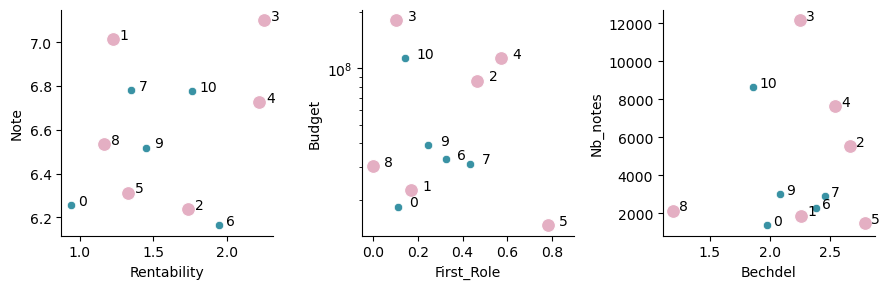

In [77]:
fig, axs = plt.subplots(1, 3, figsize=(9,3))
step = np.int(np.floor(len(gradient)/Knee))
couleur_step = np.arange(0,len(gradient),8)
feats = ['Rentability', 'Note', 'First_Role', 'Budget', 'Bechdel', 'Nb_notes']
data = Data_Clusters.groupby(['clusters']).mean().reset_index()
clust = data['clusters']
for j in range(3):
    
    x = data[feats[j*2]]
    y = data[feats[j*2+1]]
    sns.scatterplot(x=x, y=y, color=Colors[2], ax=axs[j])
    
    x2 = data.loc[data['clusters'].isin(Choix_clust),feats[j*2]]
    y2 = data.loc[data['clusters'].isin(Choix_clust),feats[j*2+1]]
    sns.scatterplot(x=x2, y=y2, color=Colors[5], ax=axs[j], s=100)

    for i in range(Knee):
        axs[j].annotate(f'{clust.iloc[i]}', (x.iloc[i]+0.05, y.iloc[i]))
    for spine in ['top', 'right']:
        axs[j].spines[spine].set_visible(False)
        
    axs[1].set(yscale='log', xlim=[-0.05, 0.9])
    plt.tight_layout()
    plt.savefig('Clusters.png')

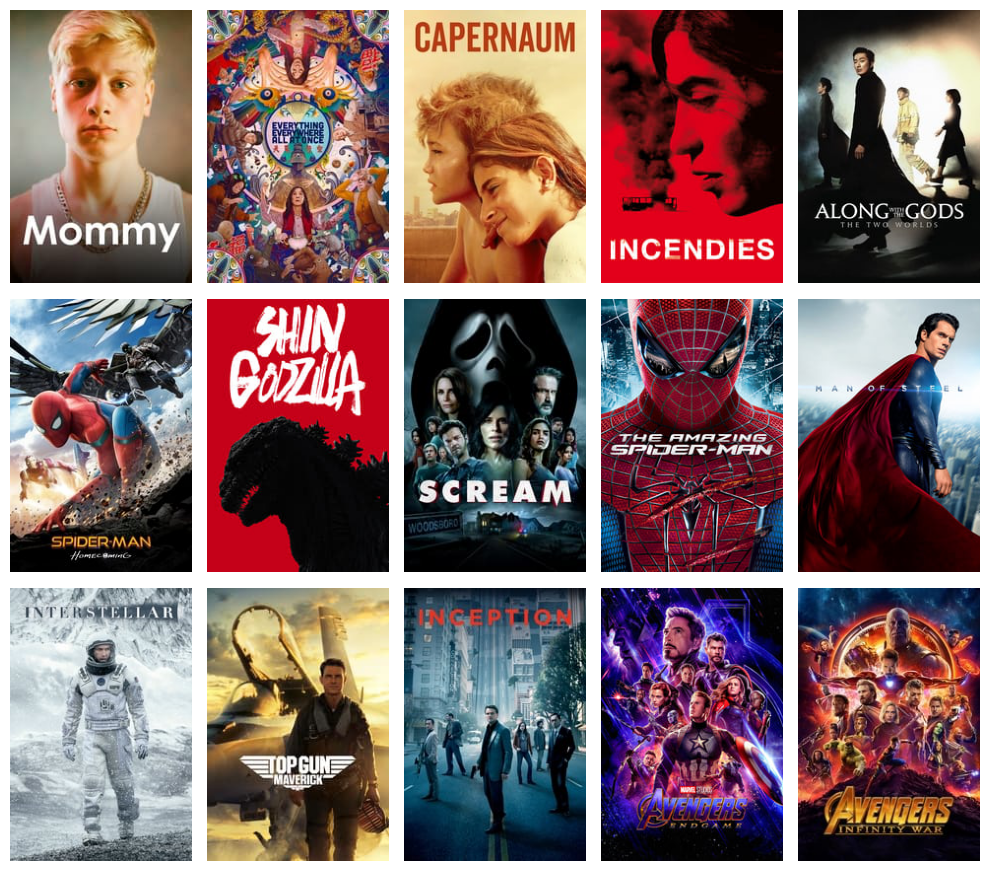

In [78]:
fig, axs = plt.subplots(3,5,figsize=(10,10))
for clust in range(3):
    cluster = Choix_clust[clust]
    Film_pop = Data_Clusters.loc[Data_Clusters['clusters']==cluster, 'Note'].sort_values(ascending=False)[:5]
    for i in range(5):
        index = Film_pop.index[i]
        url = Data_Brut.loc[index,'Poster']
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        axs[clust,i].imshow(img)
        axs[clust,i].axis('off')
    plt.tight_layout()
    plt.savefig('Affiches films.png')

In [79]:
# Je récupère mes centroids
centroids = pipe['kmeans'].cluster_centers_
sorted_centroid_features_idx = np.abs(centroids).argsort(axis=1)[:,::-1]
sorted_centroid_features_values = np.take_along_axis(centroids, sorted_centroid_features_idx, axis=1)

In [80]:
# Je les mets dans un nouveau dataframe
col = pipe['preprocessor'].get_feature_names_out()
Important_features_cluster = pd.DataFrame([])
Important_features_values = pd.DataFrame([])
for i in Choix_clust:
    feats = col[sorted_centroid_features_idx[i]]
    values = sorted_centroid_features_values[i]
    Important_features_cluster[f'cluster_{i}'] = feats
    Important_features_values[f'cluster_{i}'] = values

In [81]:
Important_features_cluster.head(5)

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_8
0,Runtime,Reboot,Budget,Spin_off,Ratio,Role_First_Woman
1,Drama,Budget,Nb_notes,Taille_Cast,Role_First_Woman,Ratio
2,Suite,Action,Suite,Budget,First_Role,Drama
3,Adaptation,Nb_notes,Runtime,Nb_notes,Runtime,Action
4,Budget,First_Role,Taille_Cast,Action,Drama,Thriller


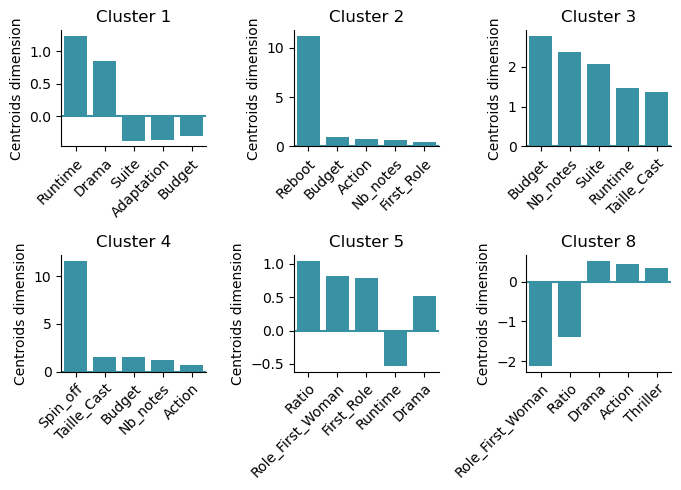

In [82]:
# Je plot les centroids
fig, axs = plt.subplots(2,3, figsize=(7,5))
for i in range(6):
    clust = Important_features_cluster.columns[i]
    label = Important_features_cluster[clust].values[:5]
    data = Important_features_values[clust].values[:5]
    if i < 3:
        sns.barplot(x=label, y=data, color=Colors[2], ax=axs[0,i], saturation=1)
        plt.setp(axs[0,i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axs[0,i].axhline(0, color=Colors[2])
        axs[0,i].set(title=f'Cluster {Choix_clust[i]}', ylabel='Centroids dimension')
        for spine in ['top', 'right']:
            axs[0,i].spines[spine].set_visible(False)
    else :
        sns.barplot(x=label, y=data, color=Colors[2], ax=axs[1,i-3], saturation=1)
        plt.setp(axs[1,i-3].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axs[1,i-3].axhline(0, color=Colors[2])
        axs[1,i-3].set(title=f'Cluster {Choix_clust[i]}', ylabel='Centroids dimension')
        for spine in ['top', 'right']:
            axs[1,i-3].spines[spine].set_visible(False)
        
plt.tight_layout()
plt.savefig('Centroids.png')

In [83]:
# Je garde seulement les clusters que j'ai choisi précédemment
data_final = Data_Clusters.loc[Data_Clusters['clusters'].isin(Choix_clust)]

In [84]:
data_final.groupby(['clusters']).mean().sort_values(ascending=False, by=['Rentability'])

,Runtime,Budget,Nb_notes,Suite,Adaptation,Spin_off,Reboot,Taille_Cast,First_Role,Ratio,Role_First_Woman,Direct_Woman,Bechdel,First_Man_Age,First_Woman_Age,Note,Revenue,Rentability
clusters,,,,,,,,,,,,,,,,,,
3,139.298969,1.803196e+08,12172.804124,0.855670,0.175258,0.0,0.0,76.185567,0.103093,0.284536,3.041237,0.020619,2.253012,44.072165,34.373626,7.100969,7.967770e+08,2.247423
4,119.357143,1.138214e+08,7670.642857,0.285714,0.000000,1.0,0.0,78.857143,0.571429,0.485714,4.000000,0.071429,2.545455,40.250000,32.000000,6.725214,4.354050e+08,2.214286
2,114.866667,8.613333e+07,5565.600000,0.200000,0.000000,0.0,1.0,46.733333,0.466667,0.400000,4.133333,0.000000,2.666667,38.500000,36.066667,6.236267,2.694279e+08,1.733333
5,101.626866,1.470987e+07,1507.726368,0.000000,0.000000,0.0,0.0,30.047264,0.783582,0.583582,4.763682,0.164179,2.793594,43.510714,36.500000,6.313311,4.059973e+07,1.325871
1,134.966184,2.252896e+07,1883.541063,0.004831,0.000000,0.0,0.0,37.444444,0.169082,0.348792,3.787440,0.053140,2.259843,42.994845,36.221675,7.015179,5.573979e+07,1.222222
8,112.319149,3.041759e+07,2153.845745,0.074468,0.074468,0.0,0.0,37.590426,0.000000,0.093617,0.611702,0.015957,1.188034,43.591398,36.627907,6.534910,6.753358e+07,1.164894


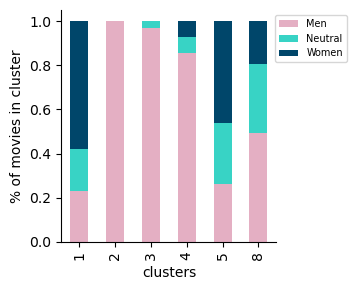

In [85]:
ax = (data_final[['clusters','Preference']]
      .groupby(['clusters'])
      .value_counts(normalize=True).unstack()
      .plot.bar(figsize=[4,3], stacked=True, color=[Colors[5], Colors[3], Colors[1]]))

for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    
ax.legend(loc='upper right', prop={'size': 7}, bbox_to_anchor=(0, 1, 1.35, 0))
ax.set(ylabel='% of movies in cluster')
plt.tight_layout()
plt.savefig('Pref in clusters.png')

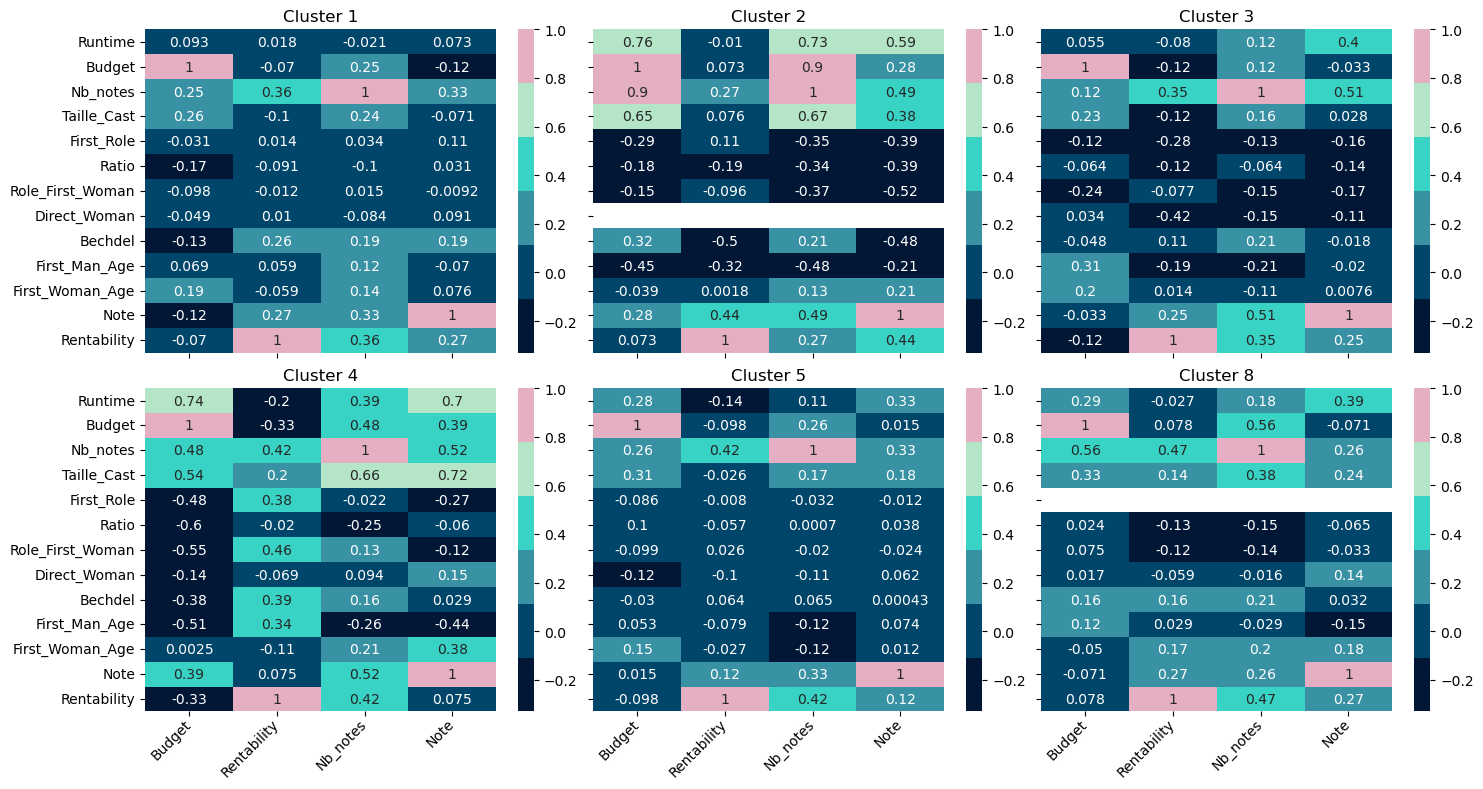

In [86]:
fig, axs = plt.subplots(2,3, figsize=(15, 8), sharey=True, sharex=True)

for i in range(6):
    if i < 3:
        data = data_final.loc[data_final['clusters']==Choix_clust[i]]
        corr_data = data.corr().loc[:,['Budget', 'Rentability', 'Nb_notes', 'Note']]
        sns.heatmap(corr_data.drop(['Reboot', 'Adaptation', 'Suite', 'Spin_off', 'clusters', 'Revenue'],axis=0), 
                    cmap=gradient, vmin=-0.33, ax=axs[0,i], annot=True)
        
        for spine in ['top', 'right']:
            axs[0,i].spines[spine].set_visible(False)
        _ = plt.setp(axs[0,i].get_xticklabels(), rotation=45, ha="right", va="center", rotation_mode="anchor")
        axs[0,i].set(title=f'Cluster {Choix_clust[i]}')
        plt.tight_layout()
    else :
        data = data_final.loc[data_final['clusters']==Choix_clust[i]]
        corr_data = data.corr().loc[:,['Budget', 'Rentability', 'Nb_notes', 'Note']]
        sns.heatmap(corr_data.drop(['Reboot', 'Adaptation', 'Suite', 'Spin_off', 'clusters', 'Revenue'],axis=0), 
                    cmap=gradient, vmin=-0.33, ax=axs[1,i-3], annot=True)
        
        for spine in ['top', 'right']:
            axs[1,i-3].spines[spine].set_visible(False)
        _ = plt.setp(axs[1,i-3].get_xticklabels(), rotation=45, ha="right", va="center", rotation_mode="anchor")
        axs[1,i-3].set(title=f'Cluster {Choix_clust[i]}')
        plt.tight_layout()
plt.savefig('Correlation_clusters.png')